<a href="https://colab.research.google.com/github/SaketMunda/introduction-to-nlp/blob/master/skimlit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Milestone Project : SkimLit 🗒 🔥

In this project, we're going to be putting what we've learned during the `introduction_to_nlp` notebook.

We're going to be replicating the deep learning model behind the 2017 paper [PubMed 200K RCT : a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

RCT : Randomized Controlled Trial abstracts

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

Input : an abstract of a RCT

Output : What role does each sentence serve in the abstract ?

**Problem**:

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

**Solution**:

Create an NLP model to classify abstract sentences into the role they play (e.g objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit) and dive deeper when necessary.

**Dataset**:

[PubMed RCT200k from Github](https://github.com/Franck-Dernoncourt/pubmed-rct)


**Replicating Model Architecture**:

[Neural Networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf)



In [1]:
# check the gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f4b2c583-d025-5440-69be-6306adb3ef5c)


## Get the Data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.32 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


So we have 4 major directories and each folder contain some txt files, let's check one of it,

In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


- `dev.txt` contains the abstracts for validation set
- `test.txt` is for testing
- `train.txt` is for the training the model

For the baseline and experiment purpose we can start with 20K data in which the numbers are replaces with @ sign, so basically we will use folder `PubMed_20k_RCT_numbers_replaced_with_at_sign`

In [4]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Because our data is in the text files/format, we need to preprocess it first to get ready for the model training and also to get familiar with we need to convert it to something that we will be easy for us to understand.

So let's write a function for it to read the text files,

In [5]:
def get_lines(filename):
  """
  Reads a filename(.txt) and returns the lines of text as a list
  """
  with open(filename,'r') as f:
    return f.readlines()    

In [7]:
# try with training samples
train_lines = get_lines(data_dir+'train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

These are the lines of each individual abstracts (which are separated using the `###(_id)` at the start and `\n` in the end) and inside each abstract, there are multiple lines which have labels and texts which are separated with `\t`.

So we need to make this more readable for us and also for the machine. For this we can write a function which will gives us the list of dictionaries in the below format,

```
[{
  'line_number':0,
  'target':'OBJECTIVE',
  'text':'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'total_lines':11,
}]
```


In [19]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns the list of dictionaries of abstract line data.

  Takes the filename as input, reads its contents and sorts through each line,
  extracting things like the target label, text of the sentence, how many lines in
  that abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_lines_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
        line_data={}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number 
        line_data['total_lines'] = len(abstract_lines_split) - 1 # total lines, starting from 0
        abstract_samples.append(line_data)

    else:
      abstract_lines+=line
  
  return abstract_samples

In [20]:
# get data from files and preprocess it
%%time

train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 413 ms, sys: 44.2 ms, total: 457 ms
Wall time: 459 ms


(180040, 30212, 30135)

Okay now we just created a list of dictionaries for each samples, let's see training samples how it looks

In [21]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

For more visual understanding, let's use `pandas` Dataframe

In [22]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.shape

(180040, 4)

In [12]:
train_df.shape, val_df.shape, test_df.shape

((180040, 4), (30212, 4), (30135, 4))

In [23]:
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Now our dataframe is ready, we can use data analysis functions of pandas,

In [24]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

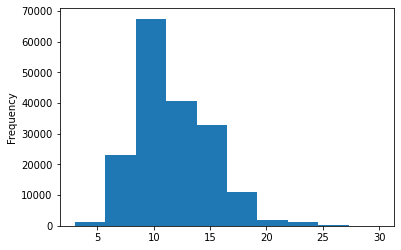

In [26]:
# check the hist distribution of our abstract lenghts
train_df.total_lines.plot.hist();

Looks like most of the abstracts are around 7 to 15 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

### Get lists of sentences

We we build our deep learning models, one of its main inputs will be a list of string (the lines of an abstract).

In [27]:
# convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

# check first 10 sentences of training set
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML Models require numeric labels)

We're going to create label encoded and one hot encoded labels.

Tensorflow CategoriCalCrossEntropy loss function likes to have one hot encoded labels, so we also need one hot encoded labels but for baseline model like Scikit-Learn, label encoded is enough.

In [31]:
# one hot encoded
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [32]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In the above OneHotEncoder method passing `sparse=False` because if don't then tensorflow will throw an error while converting it into tensors.

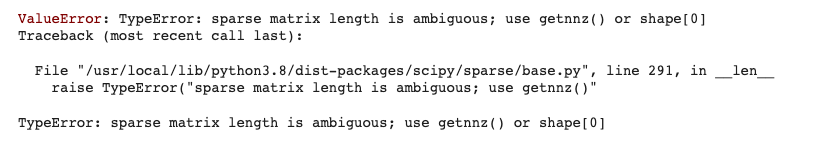

### Label Encoded


In [35]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check the label encoded train labels
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

Let's get the classnames from the trained `LabelEncoder` using `classes_` attribute

In [36]:
# get the class names and number of classes from LabelENcoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object), 5)